In [1]:
import summarization as sm
from models.utils import utils

In [2]:
dataset = sm.use_dataset(sm.GIGAWORD_DATASET)
#select the dataset to be used
#availabe datasets: GIGAWORD_DATASET, CNN_DATASET

In [3]:
VOCAB_SIZE = 50000
BATCH_SIZE = 16
EMBED_DIM = 200
#the value of EMBED DIM can only be one of the following values: 50, 100, 200, 300.
HIDDEN_DIM = 128
MAX_ENCODER_LEN = 90
MAX_DECODER_LEN = 20
LOG_EVERY = 600
VALIDATION_LOG_EVERY = 10
override_old_preprocessing = True
use_pretrained_embedding = False

In [4]:
preprocessing_path = sm.PATH + '\\prepared-datasets\\' + dataset + '\\vocab=' + str(VOCAB_SIZE) + '.pkl'
#whenever you change the BATCH_SIZE, VOCAB_SIZE, MAX_ENCODER_LEN or MAX_DECODER_LEN make sure to override preprocessing.
if override_old_preprocessing:
    p, train_set, test_set, validation_set = sm.preprocess_data(
        VOCAB_SIZE,
        BATCH_SIZE, 
        max_input_len=MAX_ENCODER_LEN,
        max_target_len=MAX_DECODER_LEN
    )
    data_dict = {'preprocessor': p, 'train_set': train_set, 'test_set': test_set, 'validation_set': validation_set}
    utils.save(data_dict, preprocessing_path)
    del(data_dict)
    #the dataset is preprocessed and saved to disk you can load it using utils.load(preporcessing_path).

preprocessing started
preprocessing time:  270.38354949999996
preprocessing finished


In [5]:
data = utils.load(preprocessing_path, with_info=False)
p = data['preprocessor']
train_set = data['train_set']
validation_set = data['validation_set']
test_set = data['test_set']
del(data)

In [6]:
print(len(train_set))
print(len(validation_set))
print(len(test_set))

237467
11835
121


In [7]:
metrics = sm.instantiate_metrics(p, utils.SEQ2SEQ, enable_visio=True)
#this functions allows us to log and visualize our metrics.
#if you don't want to visualize the metrics call the function with enable_visio=False.

metrics instantiated


In [8]:
EOS_TOKEN = p.get_eos_token()[0][0]
#that's the end of string token.

In [9]:
embedding_matrix = None
if use_pretrained_embedding:
    embedding_matrix = sm.create_embedding_matrix(p, VOCAB_SIZE, EMBED_DIM, train_set)
    #creates the embedding weights from pretrained GloVe embedding.

In [10]:
model, attention, optimizer, loss_function = sm.instantiate_model(
utils.SEQ2SEQ, #the type of the model.
VOCAB_SIZE, 
EMBED_DIM, 
HIDDEN_DIM,
0.001, #the learning rate.
True, #if true a bidirectional encoder will be used.
MAX_ENCODER_LEN,
MAX_DECODER_LEN,
EOS_TOKEN,
decoder_num_layers=2, #for our seq2seq model the decoder_num_layers must always be equal to 2.
dropout_rate=0.3,
embedding_weights=embedding_matrix #if embedding matrix is None the weights for the embedding layer are initialized randomly.
)
#this function creates the model, optimizer and the loss function in train mode.

C:\python\Anaconda3\envs\tf-gpu\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


model created
model moved to device:  cuda
optimizer created
loss function created


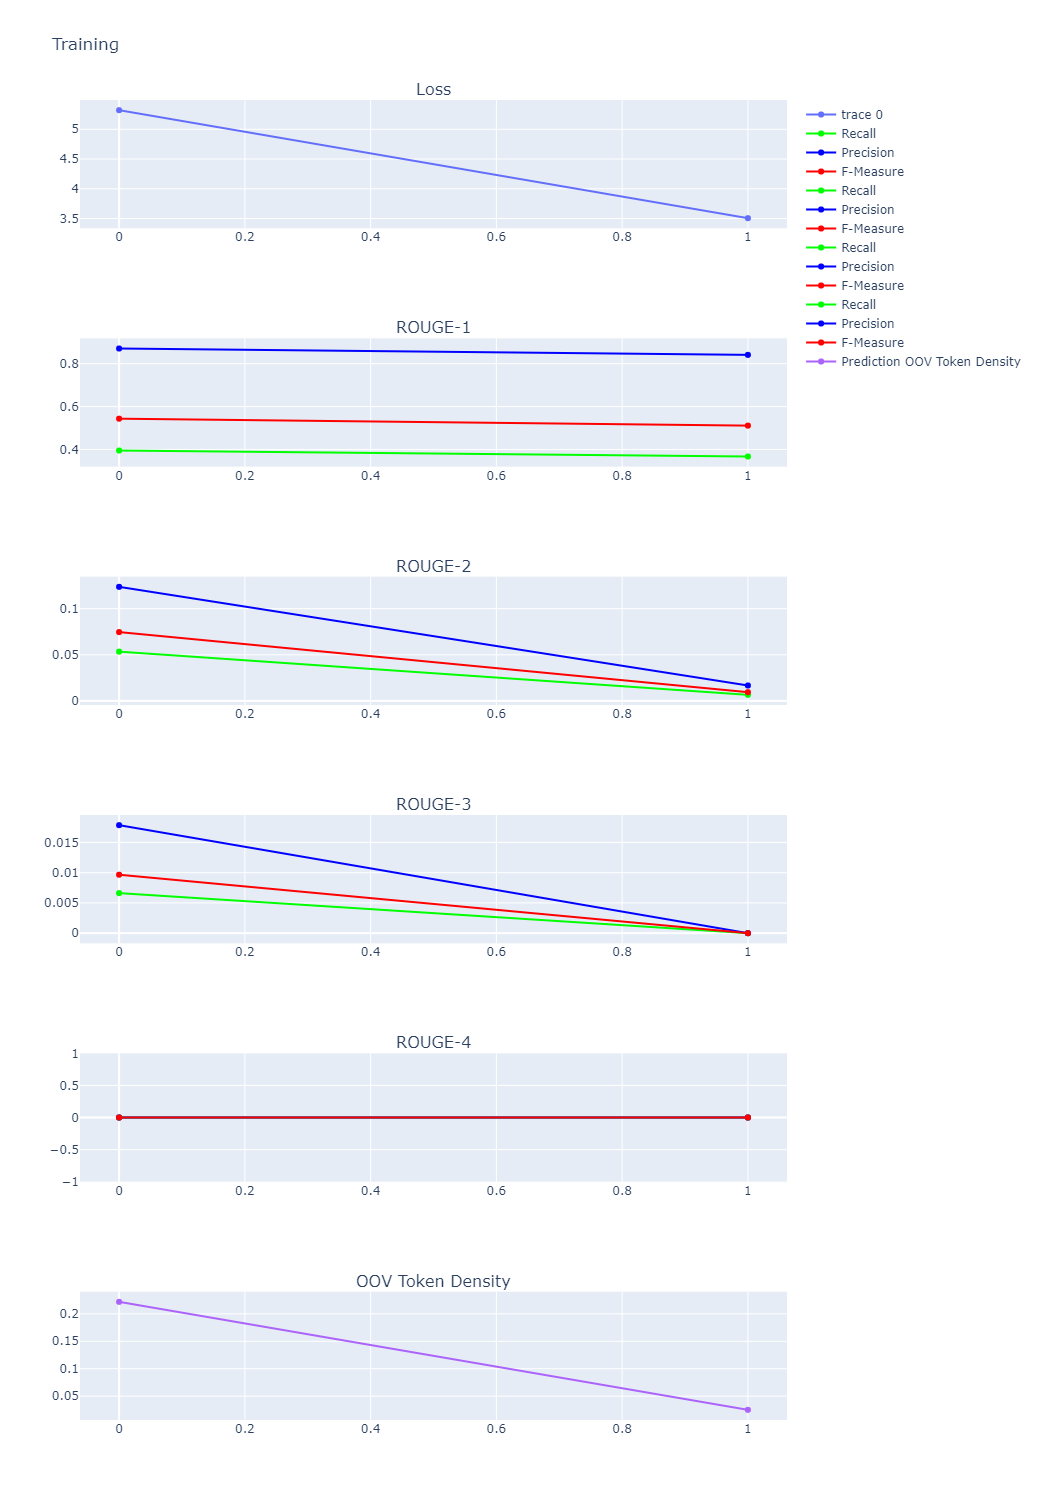


------------------Train sample:-------------------


Input:

 <sos> european regulators delayed the proposed takeover of sun microsystems by the software company oracle on thursday , indicating that the combination could squelch the growth of a popular , free corporate database program owned by sun . <eos>


Reference:

 <sos> new snag for oracle in sun deal <eos>


System:

 china 's to to to to


KeyboardInterrupt: 

In [11]:
model, optimizer, loss_function, epochs_num = sm.start_training(
model, #the model obtained from sm.instantiate_model().
attention, #resposible for attention computation.
optimizer, #the optimizer obtained from sm.instantiate_model().
loss_function, #the loss function obtained from sm.instantiate_model().
0, #the number of previous epochs, in case you are loading the model from checkpoint.
train_set, #the train set from the dataset.
validation_set, #the validation set from the dataset.
1, #the number of total epochs needed to finish the training.
metrics, #the metrics to be logged obtained from sm.instantiate metrics.
LOG_EVERY, #the metrics are logged every LOG_EVERY tarining iterations.
VALIDATION_LOG_EVERY #the model is validated after every epoch, during validation the metrics are logged every VALIDATION_LOG_EVERY iterations.
)
#training_started.
#to load a model from a checkpoint use utils.load(checkpoint_path).